**4th European Conference on Social Networks**

**Workshop: Introduction to Python's Graph-Tool**
# graph-tool SBM - Inference.

**Author**: <a href='https://marcosoliveira.info/'>Marcos Oliveira</a>, GESIS - Leibniz Institute for the Social Sciences

**Version**: 9 Sep 2019

**Description**: This is an introduction to stochastic block modelling in Python using the <code>graph-tool</code> library. 
    
## Imports and Settings

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

<div class="alert alert-danger">
    You need the <code>graph_tool</code> library in your machine. Sometimes the installation is challenging. This <a href=https://git.skewed.de/count0/graph-tool/wikis/installation-instructions>page</a> might help you.
</div>

In [2]:
import graph_tool.all as gt
print(gt.__version__)

2.28 (commit e5760dfc, Thu Jun 6 15:14:05 2019 +0100)


<div class="alert alert-warning">
    If you running this notebook via the GESIS infrastructure, you should set the number of threads as the following; otherwise, it will be slow.
</div>

In [3]:
# gt.openmp_set_num_threads(2)

The following are helper functions, as describe in the comments:

In [4]:
def node_colors(g, group_memberships):
    """
        Given a graph and a group membership, this function returns 
        a vertex property with node color for each group.
    """
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
    to_rgb = lambda h: list(int(h[i:i+2], 16)/255. for i in (0, 2, 4))
    vertex_color = g.new_vertex_property('vector<double>')
    for m, v in zip(group_memberships, g.vertices()):
        vertex_color[g.vertex(v)] = tuple(to_rgb(colors[m%len(colors)][1:]) + [255.0])
    return vertex_color

def generate_assortative_block_mix(group_sizes, p_ii, p_ij):
    """
        This function creates the propensity matrix given the group sizes and 
        the probability of inter- and intra-group connections. 
    """
    groups = len(group_sizes)
    membership = np.concatenate([
        np.repeat(i, g) for (i, g) in zip(range(groups), group_sizes)
    ])
    propensity = np.zeros([groups, groups])
    for i in range(groups):
        for j in range(groups):
            if i == j:
                propensity[i, j] = p_ii * group_sizes[i] * group_sizes[j] 
            else:
                propensity[i, j] = p_ij * group_sizes[i] * group_sizes[j] / 2.    
    return membership, propensity

def reset_rng():
    """
        This function sets the seed of the random number generator, so we have
        reproducible results.
    """
    np.random.seed(42)
    gt.seed_rng(42)
    
def block_assignment(membership):
    """
        This function converts a dictionary of membership (e.g., {0: [0, 3], 1: [1, 2]}) 
        into a list of membership (e.g., [0, 1, 1, 0])
    """
    b = np.zeros(len(np.concatenate(list(membership.values()))), dtype=int)
    for b_ in membership:
        b[membership[b_]] = b_
    return b

# Inferring large-scale structures

# The Stochastic Block Model

Let's start with a simple graph. 

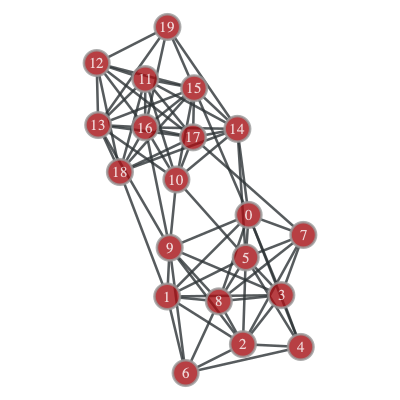

In [5]:
reset_rng() # we reset the random number generator to have same example/layout
group_sizes = [10, 10]
simple_graph = gt.generate_sbm(*generate_assortative_block_mix(group_sizes, 1.0, 0.2))
gt.remove_parallel_edges(simple_graph)
gt.remove_self_loops(simple_graph)
pos = gt.sfdp_layout(simple_graph)
gt.graph_draw(simple_graph, output_size=(400, 400), vertex_text=simple_graph.vertex_index, vertex_font_size=15, pos=pos);

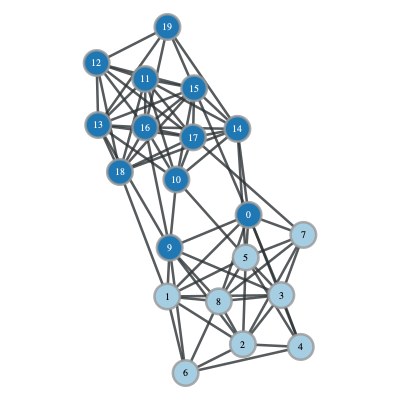

In [6]:
# membership 1
b1 = block_assignment({0: [1, 5, 2, 3, 4, 6, 7, 8],
                       1: [0, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]})
gt.graph_draw(simple_graph, output_size=(400, 400), vertex_fill_color=node_colors(simple_graph, b1), 
              vertex_text=simple_graph.vertex_index, vertex_font_size=10, pos=pos);    

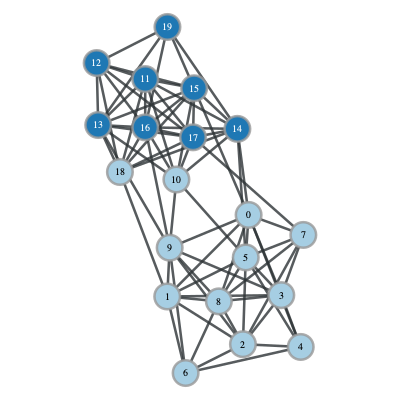

In [7]:
# membership 2
b2 = block_assignment({0: [0, 1, 2, 3, 4, 6, 7, 8, 9, 5, 10, 18],
                       1: [12, 13, 14, 15, 16, 17, 19, 11]})
gt.graph_draw(simple_graph, output_size=(400, 400), vertex_fill_color=node_colors(simple_graph, b2), 
              vertex_text=simple_graph.vertex_index, vertex_font_size=10, pos=pos);    

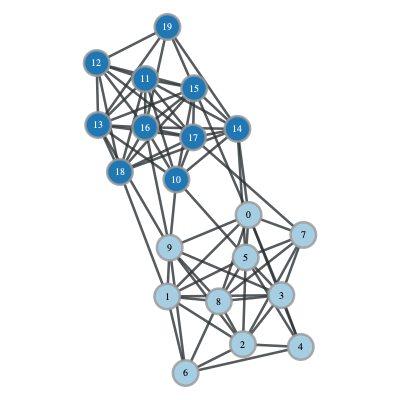

In [8]:
# membership 3
b3 = block_assignment({0: [0, 1, 2, 3, 4, 6, 7, 8, 9, 5],
                       1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]})
gt.graph_draw(simple_graph, output_size=(400, 400), vertex_fill_color=node_colors(simple_graph, b3), 
              vertex_text=simple_graph.vertex_index, vertex_font_size=10, pos=pos);    

In [9]:
print("b1 =", b1)
print("b2 =", b2)
print("b3 =", b3)

b1 = [1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
b2 = [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1]
b3 = [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


For a network $G$, we have three different $\mathbf{b}$. Which one is the best to explain our data?

<div class="alert alert-info">
Did you notice that our question is different in the case of modularity maximization?
</div>

## The entropy of stochastic blockmodel ensembles
To answer this question, first let's think a bit about our models. Specifically, let's examine the following $e_{rs}$ matrices:

In [10]:
group_sizes = [200, 200]

In [11]:
h_ii, h_ij = 0.1, 0.1
membership, propensity = generate_assortative_block_mix(group_sizes, h_ii, h_ij)
propensity

array([[4000., 2000.],
       [2000., 4000.]])

In [12]:
h_ii, h_ij = 0.1, 0.01
membership, propensity = generate_assortative_block_mix(group_sizes, h_ii, h_ij)
propensity

array([[4000.,  200.],
       [ 200., 4000.]])

In [13]:
h_ii, h_ij = 0.1, 0.001
membership, propensity = generate_assortative_block_mix(group_sizes, h_ii, h_ij)
propensity

array([[4000.,   20.],
       [  20., 4000.]])

Intuitively, which of the above matrices do specify the highest number of graphs? 

Plots will help us:

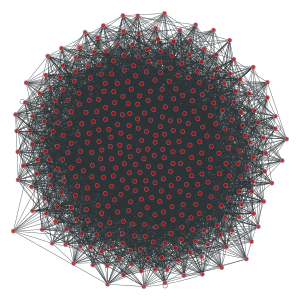

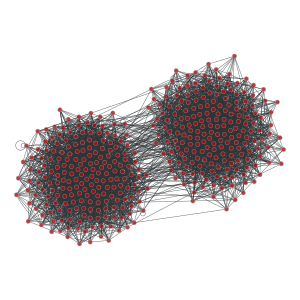

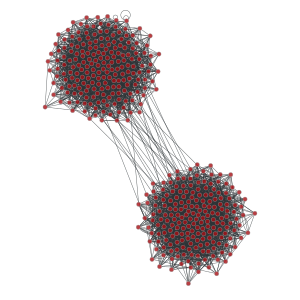

In [14]:
h_ii, h_ij = 0.1, 0.1
g = gt.generate_sbm(*generate_assortative_block_mix(group_sizes, h_ii, h_ij))
gt.graph_draw(g, output_size=(300, 300));    

h_ii, h_ij = 0.1, 0.01
g = gt.generate_sbm(*generate_assortative_block_mix(group_sizes, h_ii, h_ij))
gt.graph_draw(g, output_size=(300, 300));    

h_ii, h_ij = 0.1, 0.001
g = gt.generate_sbm(*generate_assortative_block_mix(group_sizes, h_ii, h_ij))
gt.graph_draw(g, output_size=(300, 300));    

We denote the number of graphs in a ensemble as $\Omega$. Finding out this number is a combinatorial problem that we will skip here (the interested reader can check it <a href="https://arxiv.org/abs/1112.6028/">here</a>). 

Yet, note that the third $e_{rs}$ allows less edges between groups, decreasing the possibilities of graph instances. Note as well that a graph from this matrix seems to be more 'ordered'&mdash;we can clearly see two groups. 

This order is related to the the so-called *microcanonical enropy of stochastic blockmodel ensembles*, defined as $\mathcal{S} = \ln \Omega$. Low entropy values indicate more order in the ensemble. 

### How is this related to finding out the best group assignment? 

Given a network realization and a group assignment, we can define the log-likelihood function $\mathcal{L} = \ln \mathcal{P}$, where $\mathcal{P}$ is the probability of observing the network. This function can guide us to find the most likely group assigment given a network. 

If we assume that each graph in an ensemble has the same probability, $\mathcal{P} = 1/\Omega$. Therefore, $\mathcal{L} = - \mathcal{S}$. 

That is, maximizing the log-likelihood function is equivalent to minimize the entropy. 


<div class="alert alert-info">
Can you see the diference between this approach and modularity maximization?
</div>


Let's use `graph-tool` to measure the entropy:

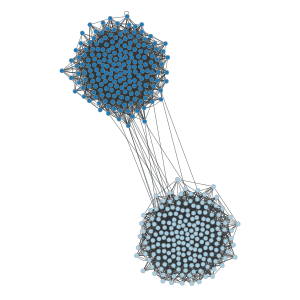

In [15]:
h_ii, h_ij = 0.1, 0.001
membership, propensity = generate_assortative_block_mix(group_sizes, h_ii, h_ij)
g = gt.generate_sbm(membership, propensity)
gt.graph_draw(g, output_size=(300, 300), vertex_fill_color=node_colors(g, membership));    

The `BlockState` class represents the stochastic block model state of a graph (documentation [here](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.blockmodel.BlockState)). We can set the state as the follows:

In [16]:
block_state = gt.BlockState(g, membership, deg_corr=False)

This class has a useful method:
  - <code>gt.BlockState.<b>entropy</b>()</code>: Calculate the entropy associated with the current block partition.
  
For now, we use this with the following parameters: 
  - <code>gt.BlockState.<b>entropy</b>(adjacency=True, dl=False, dense=True, multigraph=False, exact=True)</code>

In [17]:
block_state.entropy(adjacency=True, dl=False, dense=True, multigraph=False, exact=True)

13225.309075410449

Let's create this helper function that will make our life easier:

In [18]:
def entropy(g, membership):
    block_state = gt.BlockState(g, membership, deg_corr=False)
    return block_state.entropy(adjacency=True, dl=False, dense=True, multigraph=False, exact=True)

This helper function creates a ```BlockState``` object and then calculates the entropy of it. 

With this function, let's calculate the entropy of another network:

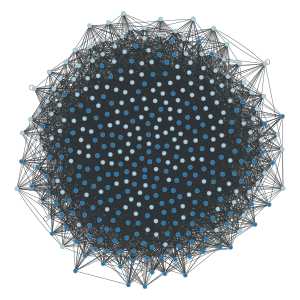

In [19]:
h_ii, h_ij = 0.1, 0.1
membership, propensity = generate_assortative_block_mix(group_sizes, h_ii, h_ij)
g = gt.generate_sbm(membership, propensity)
gt.graph_draw(g, output_size=(300, 300), vertex_fill_color=node_colors(g, membership));    

In [20]:
entropy(g, membership)

20913.34615629344

Our initial intuition made quite sense.


## Let's get back to our initial problem

We have a network and want to know which membership assignment explains best the data.

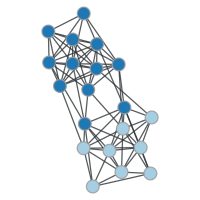

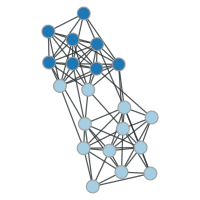

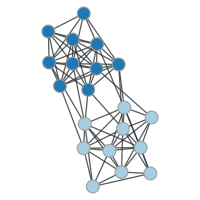

In [21]:
# b1
gt.graph_draw(simple_graph, output_size=(200, 200), vertex_fill_color=node_colors(simple_graph, b1), pos=pos);  

# b2
gt.graph_draw(simple_graph, output_size=(200, 200), vertex_fill_color=node_colors(simple_graph, b2), pos=pos);  

# b3
gt.graph_draw(simple_graph, output_size=(200, 200), vertex_fill_color=node_colors(simple_graph, b3), pos=pos);  

Entropy:

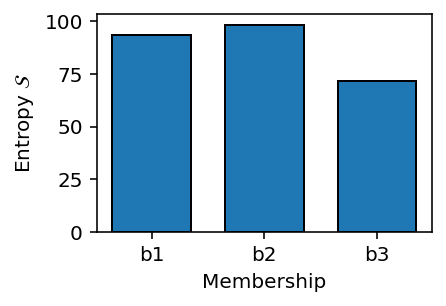

In [22]:
plt.figure(figsize=(3, 2))
plt.bar(range(3), [entropy(simple_graph, b1), 
                   entropy(simple_graph, b2), 
                   entropy(simple_graph, b3)], 
        width=0.7, edgecolor='k')
plt.xticks(range(3), ['b1', 'b2', 'b3']);
plt.ylabel(r'Entropy $\mathcal{S}$');
plt.xlabel('Membership');

Let's check a random assigment:

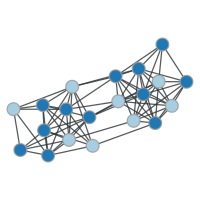

In [23]:
membership_shuffled = b1.copy()
np.random.shuffle(membership_shuffled)
reset_rng()
gt.graph_draw(simple_graph, output_size=(200, 200),vertex_fill_color=node_colors(simple_graph, membership_shuffled));  

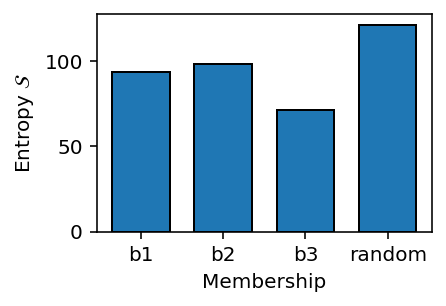

In [24]:
plt.figure(figsize=(3, 2))
plt.bar(range(4), [entropy(simple_graph, b1), 
                   entropy(simple_graph, b2), 
                   entropy(simple_graph, b3), 
                   entropy(simple_graph, membership_shuffled)], width=0.7, edgecolor='k')
plt.xticks(range(4), ['b1', 'b2', 'b3', 'random']);
plt.ylabel(r'Entropy $\mathcal{S}$');
plt.xlabel('Membership');

The third membership is the most likely one from the all four. 

## Inferring modular network structure

Given that we know $B$, let's minimize the entropy.

In [25]:
g = gt.collection.data["polbooks"]  # polbooks, football
g = gt.GraphView(g, vfilt=gt.label_largest_component(g))
g = gt.Graph(g, prune=True)
gt.remove_parallel_edges(g)
gt.remove_self_loops(g)

In [26]:
g.num_edges(), g.num_vertices()

(441, 105)

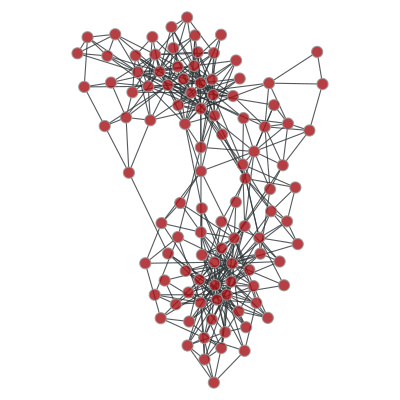

In [27]:
pos = gt.sfdp_layout(g)
gt.graph_draw(g, output_size=(400, 400), pos=pos);  

How many blocks?

In [28]:
number_of_blocks = 2

Let's use the following function from `graph-tool`:  
  - <code>gt.<b>minimize_blockmodel_dl</b>()</code>: Find the best partition.
  
For now, we will this function with the paramaters as follows:
  - <code>gt.<b>minimize_blockmodel_dl</b>(g, deg_corr=False, B_max=number_of_blocks, B_min=number_of_blocks)</code>: Find the best partition with `number_of_blocks` blocks in the graph `g`. 


In [29]:
state = gt.minimize_blockmodel_dl(g, deg_corr=False, B_max=number_of_blocks, B_min=number_of_blocks)

Some other useful methods from BlockState:
 - <code>gt.BlockState.<b>get_blocks</b>()</code> 
 - <code>gt.BlockState.<b>get_matrix</b>()</code> 

In [30]:
b = state.get_blocks()

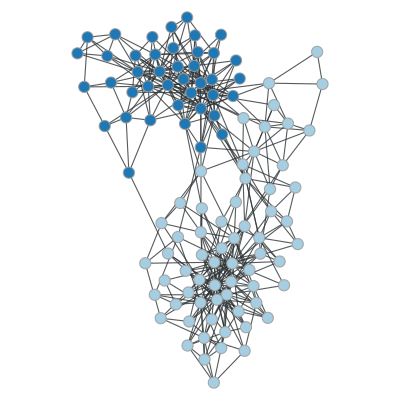

In [31]:
gt.graph_draw(g, output_size=(400, 400), pos=pos, vertex_fill_color=node_colors(g, b.a));  

Let's see the adjacency matrix and organize it based on the blocks:

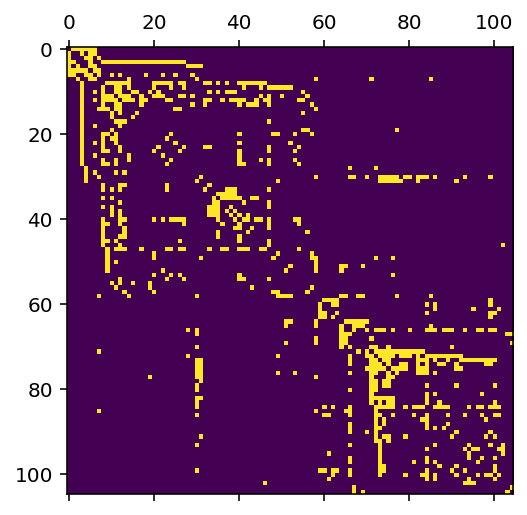

In [32]:
adjacency = gt.adjacency(g).todense()
plt.matshow(adjacency);

Just for visualization, we can order the nodes in the adjacency matrix based on the building blocks: 

In [33]:
membership_dict = {}
for i, k in zip(range(len(b.a)), b.a):
    if k not in membership_dict:
        membership_dict[k] = []
    membership_dict[k].append(i)
order = np.concatenate(list(membership_dict.values()))

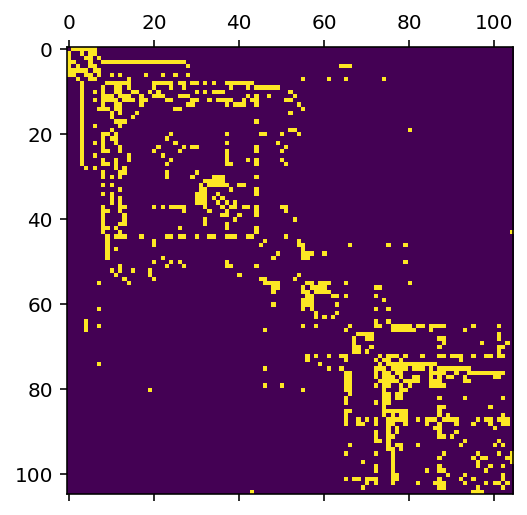

In [34]:
plt.matshow(adjacency[order][:, order])

The block matrix:

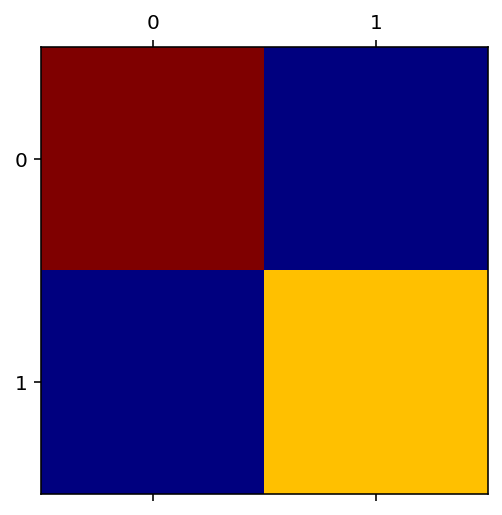

In [35]:
plt.matshow(state.get_matrix().todense(), cmap=plt.cm.jet);

How many blocks?

## How many blocks?

Can we choose $B$ using entropy? 

In [36]:
number_of_blocks_list = range(2, 50)
entropies = []
for n_b_i in number_of_blocks_list:
    state = gt.minimize_blockmodel_dl(g, deg_corr=False, B_max=n_b_i, B_min=n_b_i)
    entropies.append(state.entropy(adjacency=True, dl=False, dense=True, multigraph=False, exact=True))

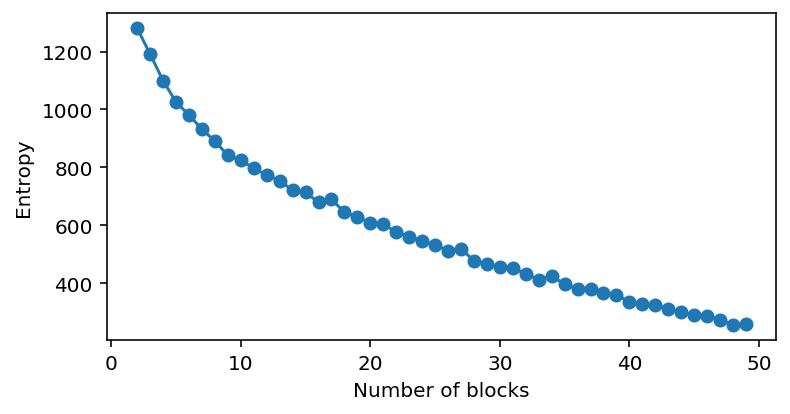

In [37]:
plt.figure(figsize=(6, 3))
plt.plot(number_of_blocks_list, entropies, marker="o")
plt.xlabel("Number of blocks")
plt.ylabel("Entropy");

Note that the entropy neglects the complexity of the model itself. It only measures the degree of order of an ensemble. 

Therefore, as $B$ increases, we start to memorize data (or noise), and we will have more order, so lower entropy. At the same time, we have a more complex model.

## Minimum description length
A way to account for the model complexity is to measure the description length. The description length provides us a way to measure the total amount of information required to describe data using an specific model. It is the number of bits required to send the compressed message plus the number of the encoding scheme. 



To calculate the description length, we just set `dl` to <b>`True`</b>, as follows:

In [38]:
state.entropy(adjacency=True, dl=True, dense=True, multigraph=False, exact=True)

1617.4000893617938

In [39]:
number_of_blocks_list = range(2, 10)
entropies = []
for n_b_i in number_of_blocks_list:
    state = gt.minimize_blockmodel_dl(g, deg_corr=False, B_max=n_b_i, B_min=n_b_i)
    entropies.append(state.entropy(adjacency=True, dl=True, dense=True, multigraph=False, exact=True))

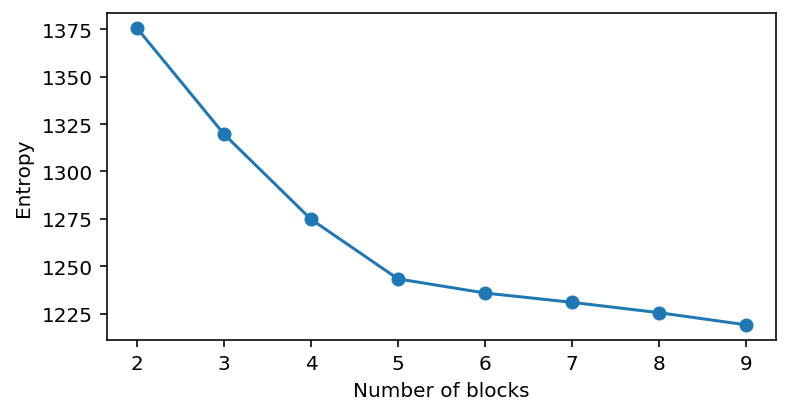

In [40]:
plt.figure(figsize=(6, 3))
plt.plot(number_of_blocks_list, entropies, marker="o")
plt.xlabel("Number of blocks")
plt.ylabel("Entropy");

## Minimizing block model description length

With `graph-tool`, we can minimize the description length of our model. 

In [41]:
state = gt.minimize_blockmodel_dl(g, deg_corr=False)

In [42]:
state.B

5

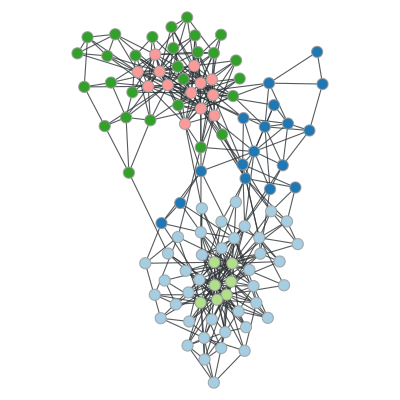

In [43]:
b = state.get_blocks()

gt.graph_draw(g, output_size=(400, 400), pos=pos, vertex_fill_color=node_colors(g, b.a));  

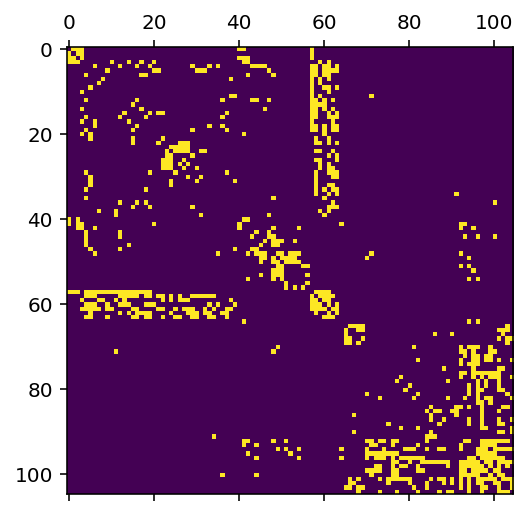

In [44]:
membership_dict = {}
for i, k in zip(range(len(b.a)), b.a):
    if k not in membership_dict:
        membership_dict[k] = []
    membership_dict[k].append(i)
order = np.concatenate(list(membership_dict.values()))
plt.matshow(adjacency[order][:, order]);

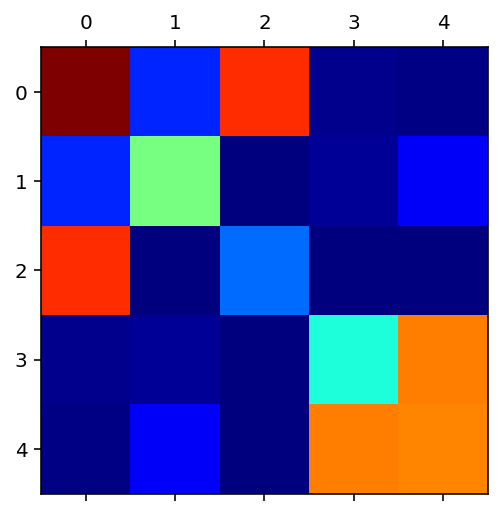

In [45]:
plt.matshow(state.get_matrix().todense(), cmap=plt.cm.jet);

### Degree heterogeneity

In [46]:
g = gt.collection.data["polbooks"]
g.num_edges(), g.num_vertices()

(441, 105)

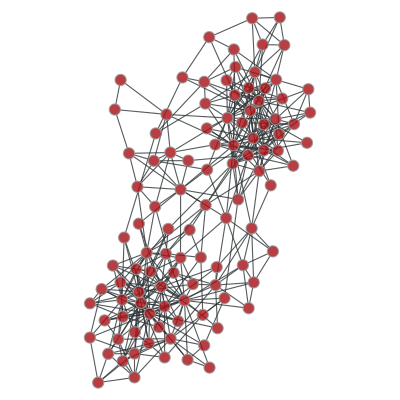

In [47]:
pos = gt.sfdp_layout(g)
gt.graph_draw(g, output_size=(400, 400), pos=pos);  

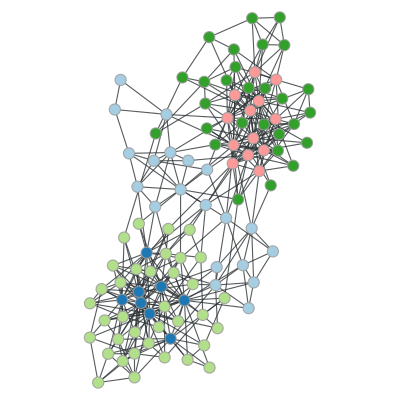

5

In [48]:
state = gt.minimize_blockmodel_dl(g, deg_corr=False)
b = state.get_blocks()
gt.graph_draw(g, output_size=(400, 400), pos=pos, vertex_fill_color=node_colors(g, b.a));  
state.B

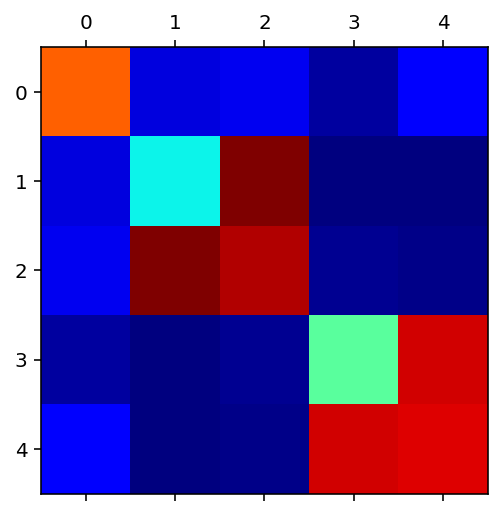

In [49]:
plt.matshow(state.get_matrix().todense(), cmap=plt.cm.jet);

The well-connected nodes can influence the block assignment.

In [50]:
degrees = [i for i in g.degree_property_map('total')]

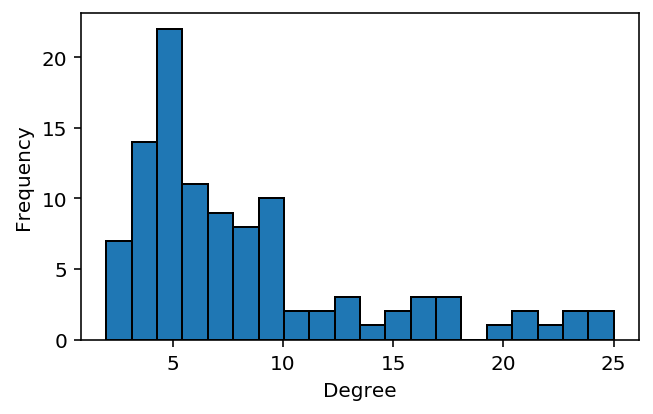

In [51]:
plt.figure(figsize=(5, 3))
plt.hist(degrees, bins=20, edgecolor='k')
plt.xlabel('Degree')
plt.ylabel('Frequency');

The degree-corrected stochastic block model includes the degree sequence in the model.

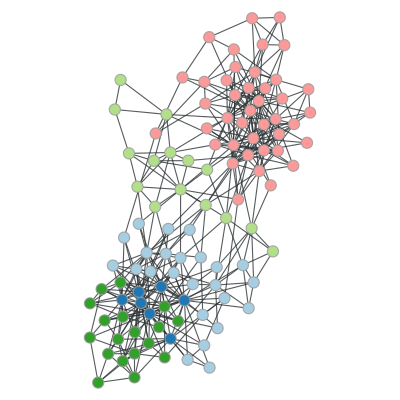

5

In [52]:
state = gt.minimize_blockmodel_dl(g, deg_corr=True)
b = state.get_blocks()
gt.graph_draw(g, output_size=(400, 400), pos=pos, vertex_fill_color=node_colors(g, b.a));  
state.B

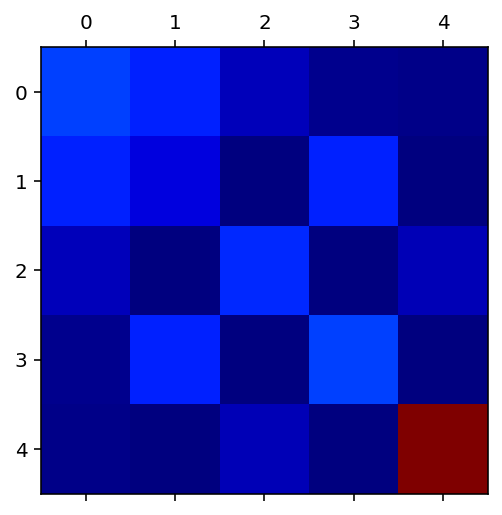

In [53]:
plt.matshow(state.get_matrix().todense(), cmap=plt.cm.jet);

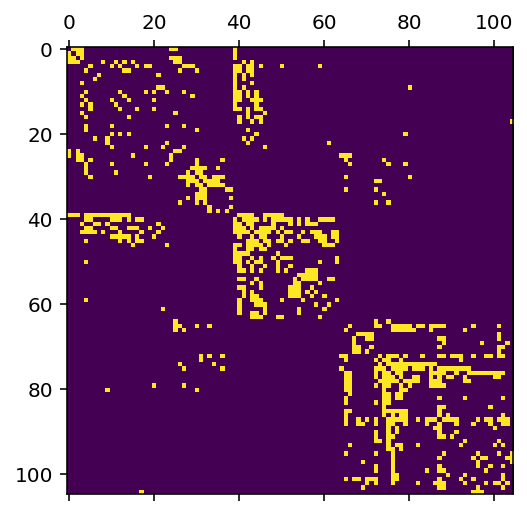

In [54]:
membership_dict = {}
for i, k in zip(range(len(b.a)), b.a):
    if k not in membership_dict:
        membership_dict[k] = []
    membership_dict[k].append(i)
order = np.concatenate(list(membership_dict.values()))
plt.matshow(adjacency[order][:, order]);

# Exercises

<div class="alert alert-success">
    <b>Exercise 1</b> 
    
Find the blocks of a network (load a network from <code>gt.collections</code> or use your own data). Investigate the differences between the degree-corrected SBM and the standard one. 

</div>

<div class="alert alert-success">
    <b>Exercise 2</b> 

Find the building blocks of a network containing meta data about its groups (e.g., 'polblogs', 'football', or your own data) and analyze if the building blocks match the meta data. 
</div>

<div class="alert alert-success">
    <b>Exercise 3</b> 

Compare the description length of the model with and without degree correction. Investigate the difference as the number of blocks $B$ increases. 
</div>

<div class="alert alert-success">
    <b>Exercise 4</b> 

Create a graph for each block in the network. For each of them, calculate the average degree, the clustering coefficient, and the average shortest path length. Compare these values with the statistics of the whole network.
</div>